### **train.csv**
- DataFrame info

```markdown
RangeIndex: 1216553 entries, 0 to 1216552
Data columns (total 13 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
- 0   transaction_id          1216553 non-null  int64
  - ex 0
  - 제거. 예측에 크게 영향을 미치지 않는 단순 식별자이므로 제거해도 무방.
- 1   apartment_id            1216553 non-null  int64  
  - 아파트 아이디 | ex) 7622
  - 유지. 아파트의 고유 ID로, 아파트마다 가격 차이가 있을 수 있으므로 유지하는 것이 좋을 수 있음.
- 2   city                    1216553 non-null  object
  - 도시 | ex) 서울특별시
  - 유지. 
- 3   dong                    1216553 non-null  object 
  - 동 | ex) 신교동
  - 제거. 너무 과하게 디테일함.
- 4   jibun                   1216553 non-null  object 
  - 지번 | ex) 6-13
  - 제거. 너무 과하게 디테일함.
- 5   apt                     1216553 non-null  object 
  - 아파트 단지 이름 | ex) 신현(101동)
  - 유지.
- 6   addr_kr                 1216553 non-null  object 
  - 주소 | ex) 신교동 6-13 신현(101동)
  - 제거. addr_kr = city + dong + jibun + apt
- 7   exclusive_use_area      1216553 non-null  float64
  - 전용면적 | ex) 84.82
  - 유지. 아파트의 전용 면적은 부동산 가격에 중요한 변수이므로 유지.
- 8   year_of_completion      1216553 non-null  int64  
  - 설립일자 | ex) 2002
  - 유지. 건축 연도는 아파트의 나이를 계산하는 데 사용될 수 있으므로 유지.
- 9   transaction_year_month  1216553 non-null  int64
  - 거래년월 | ex) 200801
  - 제거 후 변경 (transaction_year)
  - 제거 후 변경 (transaction_month)
- 10  transaction_date        1216553 non-null  object 
  - 거래날짜 | ex) 21~31
  - 제거. 유의미한 데이터는 아닌 것 같음.
- 11  floor                   1216553 non-null  int64  
  - 층 | ex) 2
  - 유지
- 12  transaction_real_price  1216553 non-null  int64  
  - 실거래가(train만 존재) | ex) 37500
  - 유지
dtypes: float64(1), int64(6), object(6)
```

- Default
  - apartment_id - 아파트 아이디
  - city - 도시
  - dong - 동
  - jibun - 지번
  - apt - 아파트 단지 이름
  - addr_kr - 주소
  - exclusive_use_area - 전용면적
  - year_of_completion - 설립일자
  - transaction_year_month - 거래년월
  - transaction_date - 거래날짜
  - floor - 층
  - transaction_real_price - 실거래가(train만 존재)

- Delete
  - 없음

- Add
  - cpi - 소비자물가지수
  - (@@Todo later) 주택가격지수
  - (@@Todo later) 연립 다세대 실거래가격지수

- 결측치
  - (@@Todo later) 정보 출력 후 나중에 처리

- 이상치
  - (@@Todo later) 정보 출력 후 나중에 처리

# To Do list
=== 문제 1
- 첫 번째 plot_results
  - Actual만 빨간색으로 나옴.
  - 가격이 0~ 400000 이상까지 잘 나옴.

- 두 번째 plot_results
  - Predicted 만 초록색으로 나옴.
  - 가격이 -8 ~ 2 로 나옴.

=== 문제 2
- Validation RMSE: 234882437570.16
- Test RMSE: 153711672690.33


In [1]:
# 패키지/라이브러리 로드
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# 데이터 불러오기
df = pd.read_csv("../../dataset/train.csv", encoding="utf-8")

# 데이터 타입 확인
print("=== 데이터 타입 확인 ===")
print(df.dtypes)

# 필요한 경우 데이터 타입 변환
# 'transaction_date'는 제거 예정이므로 변환 불필요

# 데이터 샘플링 (필요에 따라 조정)
df_sampled = df.sample(frac=0.01, random_state=2024)

# 데이터 분석하기
print("\n=== df_sampled.info() ===")
df_sampled.info()

print("\n=== df_sampled.head() ===")
print(df_sampled.head())


=== 데이터 타입 확인 ===
transaction_id              int64
apartment_id                int64
city                       object
dong                       object
jibun                      object
apt                        object
addr_kr                    object
exclusive_use_area        float64
year_of_completion          int64
transaction_year_month      int64
transaction_date           object
floor                       int64
transaction_real_price      int64
dtype: object

=== df_sampled.info() ===
<class 'pandas.core.frame.DataFrame'>
Index: 12166 entries, 1111339 to 462489
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   transaction_id          12166 non-null  int64  
 1   apartment_id            12166 non-null  int64  
 2   city                    12166 non-null  object 
 3   dong                    12166 non-null  object 
 4   jibun                   12166 non-null  object 
 5   apt         

In [8]:
# 1. transaction_year_month에서 '년', '월' 분리 (먼저 실행)
if "transaction_year_month" in df_sampled.columns:
    df_sampled["transaction_year"] = (
        df_sampled["transaction_year_month"].astype(str).str[:4].astype(int)
    )
    df_sampled["transaction_month"] = (
        df_sampled["transaction_year_month"].astype(str).str[4:6].astype(int)
    )

# 2. 필요없는 컬럼 제거 (존재하지 않으면 무시하도록 수정)
df_sampled = df_sampled.drop(
    [
        "transaction_id",
        "dong",
        "jibun",
        "addr_kr",
        "transaction_year_month",
        "transaction_date",
    ],
    axis=1,
    errors="ignore",
)

# 3. One-Hot Encoding 적용 (city와 apt)
df_sampled = pd.get_dummies(df_sampled, columns=["city", "apt"], drop_first=True)


# 4. 데이터 분리 (Feature와 Target 나누기)
X = df_sampled.drop("transaction_real_price", axis=1)
print("\nX: ", X)
print("\nData Shape:", X.shape)
print("\nFeature Data Sample: ", X[0])
print("\nFeature Names:", df_sampled.feature_names)
print("len(df_sampled.feature_names): ", len(df_sampled.feature_names))

y = df_sampled["transaction_real_price"]


# 데이터 정보 출력
print("=== df_sampled.dtypes ===\n", df_sampled.dtypes)
print("=== df_sampled.shape ===\n", df_sampled.shape)
print("=== X.info() ===\n", X.info())
print("=== X.head() ===\n", X.head())
print("=== y.info() ===\n", y.info())
print("=== y.head() ===\n", y.head())

KeyError: "None of [Index(['city', 'apt'], dtype='object')] are in the [columns]"

In [4]:
# 5. 1단계: train + validation(75%), test(25%)로 나누기
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.25, random_state=2024
)

# 6. 2단계: train(75%), validation(25%)으로 나누기
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=2024
)

In [5]:
# 7. 피처 스케일링 (StandardScaler 사용)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# X_train, X_val, X_test 각각에 대해 스케일링 적용
X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)

# y 값도 스케일링 적용
y_train = scaler_y.fit_transform(
    y_train.values.reshape(-1, 1)
).ravel()  # 스케일링 후 1차원으로 변환
y_val = scaler_y.transform(y_val.values.reshape(-1, 1)).ravel()
y_test = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

In [6]:
# 8. 선형 회귀 모델 학습
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [7]:
# 9. Validation 세트로 예측 및 RMSE 계산 (예측 값 역변환)
y_val_pred = model.predict(X_val)
y_val_pred_orig = scaler_y.inverse_transform(
    y_val_pred.reshape(-1, 1)
).ravel()  # 예측값 역변환
val_rmse = np.sqrt(
    mean_squared_error(
        scaler_y.inverse_transform(y_val.reshape(-1, 1)),
        y_val_pred_orig.reshape(-1, 1),
    )
)
print(f"Validation RMSE: {val_rmse:.2f}")

Validation RMSE: 91720426706154096.00


In [8]:
# 10. Test 세트로 예측 및 RMSE 계산 (예측 값 역변환)
y_test_pred = model.predict(X_test)
y_test_pred_orig = scaler_y.inverse_transform(
    y_test_pred.reshape(-1, 1)
).ravel()  # 예측값 역변환
test_rmse = np.sqrt(
    mean_squared_error(
        scaler_y.inverse_transform(y_test.reshape(-1, 1)),
        y_test_pred_orig.reshape(-1, 1),
    )
)
print(f"Test RMSE: {test_rmse:.2f}")

Test RMSE: 87640798594950592.00


In [9]:
# 11. 모델 디버깅용 출력

# X_train, X_val 스케일링 후 값 확인
print("=== X_train 스케일링 후 값 (첫 5개) ===")
print(X_train[:5])

print("=== X_val 스케일링 후 값 (첫 5개) ===")
print(X_val[:5])


=== X_train 스케일링 후 값 (첫 5개) ===
[[ 0.92429674  1.05068825  0.07161836 ... -0.0120895  -0.0120895
  -0.0120895 ]
 [ 0.59866717  0.20626849 -1.60292978 ... -0.0120895  -0.0120895
  -0.0120895 ]
 [-0.77800987  0.2257666   1.74616649 ... -0.0120895  -0.0120895
  -0.0120895 ]
 [ 1.47965127  1.00481434 -1.15638361 ... -0.0120895  -0.0120895
  -0.0120895 ]
 [ 1.45121444 -0.62897649  0.07161836 ... -0.0120895  -0.0120895
  -0.0120895 ]]
=== X_val 스케일링 후 값 (첫 5개) ===
[[-1.55026492 -1.45130882 -1.82620286 ... -0.0120895  -0.0120895
  -0.0120895 ]
 [ 1.67731511 -0.09785855  1.07634724 ... -0.0120895  -0.0120895
  -0.0120895 ]
 [-0.58090362 -0.62761727  0.29489144 ... -0.0120895  -0.0120895
  -0.0120895 ]
 [ 0.88470821  0.70170672 -2.16111249 ... -0.0120895  -0.0120895
  -0.0120895 ]
 [ 0.49188967 -1.30994921 -2.60765866 ... -0.0120895  -0.0120895
  -0.0120895 ]]


In [10]:
# y_val 실제 값 범위 확인
print("=== y_val 실제 값 범위 ===")
print(f"Min: {y_val.min()}, Max: {y_val.max()}")



=== y_val 실제 값 범위 ===
Min: -1.145322311060127, Max: 12.652973028241798


In [11]:
# y_val_pred 예측 값 범위 확인
print("=== y_val_pred 예측 값 범위 ===")
print(f"Min: {y_val_pred.min()}, Max: {y_val_pred.max()}")



=== y_val_pred 예측 값 범위 ===
Min: -19243703082055.293, Max: 21938859987854.766


In [12]:
# 모델 회귀 계수 확인
print("=== 모델 회귀 계수 ===")
print(model.coef_)

=== 모델 회귀 계수 ===
[ 1.47102088  0.45136491 -0.19201294 ... -0.04130554 -0.06668091
 -0.07415771]


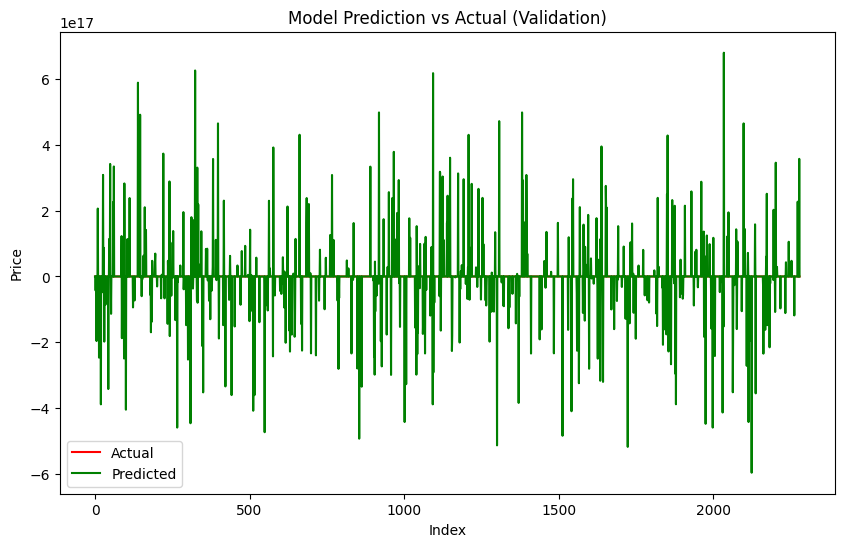

In [13]:
# 12. 시각화 함수 정의 및 적용
def plot_results(y_val_orig, y_pred_orig, title):
    plt.figure(figsize=(10, 6))
    sns.lineplot(y=y_val_orig, x=range(len(y_val_orig)), label='Actual', color='red')
    sns.lineplot(y=y_pred_orig, x=range(len(y_pred_orig)), label='Predicted', color='green')
    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# 13. 검증 세트 결과 시각화
plot_results(scaler_y.inverse_transform(y_val.reshape(-1, 1)).ravel(), y_val_pred_orig, "Model Prediction vs Actual (Validation)")
